In [2]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import preprocessing

In [3]:
import pathlib
import json
import pandas as pd
from tqdm import tqdm

In [30]:
dict(zip(set(metadata.type), range(6)))

{'why': 0, 'who': 1, 'what': 2, 'how': 3, 'where': 4, 'when': 5}

In [48]:
ds = tf.data.Dataset.from_tensor_slices({
    'txt': metadata[['ans1', 'ans2', 'ans3', 'true']].values
})

{'txt': <tf.Tensor: id=36, shape=(4,), dtype=string, numpy=
 array([b'At a park.', b'On the grass.', b'At a dining table.',
        b'On a bench.'], dtype=object)>}

In [51]:
shuff = tf.random.shuffle(tf.range(4))
label = tf.gather(tf.convert_to_tensor([0, 0, 0, 1]), shuff)
txt = tf.gather(next(iter(ds))['txt'], shuff)

label, txt

(<tf.Tensor: id=67, shape=(4,), dtype=int32, numpy=array([1, 0, 0, 0], dtype=int32)>,
 <tf.Tensor: id=75, shape=(4,), dtype=string, numpy=
 array([b'On a bench.', b'At a dining table.', b'On the grass.',
        b'At a park.'], dtype=object)>)

<tf.Tensor: id=25, shape=(4,), dtype=int32, numpy=array([0, 0, 1, 0], dtype=int32)>

In [4]:
DATA_DIR = pathlib.Path('data/')

In [5]:
list(DATA_DIR.iterdir())

[PosixPath('data/images'),
 PosixPath('data/metadata.csv'),
 PosixPath('data/dataset_v7w_telling.json')]

In [7]:
QA = json.load(open(DATA_DIR / 'dataset_v7w_telling.json', 'r'))

In [6]:
QA.keys()

dict_keys(['images', 'version', 'dataset'])

In [16]:
img_df = []
img_data = QA['images'][0]

for img_data in tqdm(QA['images']):
    for q in img_data['qa_pairs']:
        tmp_df = {'filaname': img_data['filename'],
                  'split': img_data['split']}
        tmp_df['question'] = q['question']
        tmp_df.update(dict(zip(['ans1', 'ans2', 'ans3'], q['multiple_choices'])))
        tmp_df['true'] = q['answer']
        tmp_df['type'] = q['type']
        img_df.append(tmp_df)

metadata = pd.DataFrame(img_df)
# {'filaname', 'question', 'ans1', 'ans2', 'ans3', 'true', 'type', 'split'}

100%|██████████| 28653/28653 [00:00<00:00, 165750.50it/s]


In [28]:
metadata.to_csv('data/metadata.csv', index=False)

In [8]:
words_sep = metadata[['question', 'ans1', 'ans2', 'ans3', 'true']].T.apply(lambda x: ' ' + x).sum().T
tok = preprocessing.text.Tokenizer(num_words=5000, oov_token='<UNK>')
tok.fit_on_texts(words_sep)
tok.word_index['<pad>'] = 0
tok.index_word[0] = '<pad>'

In [9]:
questions = tok.texts_to_sequences(metadata.question)
questions = preprocessing.sequence.pad_sequences(questions, padding='post')
questions.shape

(139868, 24)

In [10]:
ans1 = tok.texts_to_sequences(metadata.ans1)
ans1 = preprocessing.sequence.pad_sequences(ans1, padding='post')
ans1.shape

(139868, 19)

In [11]:
ans2 = tok.texts_to_sequences(metadata.ans2)
ans2 = preprocessing.sequence.pad_sequences(ans2, padding='post')
ans2.shape

(139868, 19)

In [12]:
ans3 = tok.texts_to_sequences(metadata.ans3)
ans3 = preprocessing.sequence.pad_sequences(ans2, padding='post')
ans3.shape

(139868, 19)

In [13]:
true = tok.texts_to_sequences(metadata.true)
true = preprocessing.sequence.pad_sequences(ans2, padding='post')
true.shape

(139868, 19)

In [19]:
img_input = tf.keras.Input((224, 224, 3), name='img_input')
img_backbone = tf.keras.applications.VGG16(input_tensor=img_input, weights='imagenet', include_top=False)
img_feat = layers.Flatten()(img_backbone.output)

In [20]:
question_input = tf.keras.Input(24, name='question_input')
q_emb = layers.Embedding(input_dim=5000, output_dim=64)(question_input)
q_av = layers.GlobalAveragePooling1D(name='question_feat')(q_emb)
# qAv
q_av

<tf.Tensor 'question_feat_1/Identity:0' shape=(None, 64) dtype=float32>

In [21]:
ans1_input = tf.keras.Input(19, name='ans1_input')
ans2_input = tf.keras.Input(19, name='ans2_input')
ans3_input = tf.keras.Input(19, name='ans3_input')
ans4_input = tf.keras.Input(19, name='ans4_input')

ans_emb = layers.Embedding(input_dim=5000, output_dim=32, name='answer_embedding')

ans1_emb = ans_emb(ans1_input)
ans2_emb = ans_emb(ans2_input)
ans3_emb = ans_emb(ans3_input)
ans4_emb = ans_emb(ans4_input)

ans1_av = layers.GlobalAveragePooling1D(name='ans1_feat')(ans1_emb)
ans2_av = layers.GlobalAveragePooling1D(name='ans2_feat')(ans2_emb)
ans3_av = layers.GlobalAveragePooling1D(name='ans3_feat')(ans3_emb)
ans4_av = layers.GlobalAveragePooling1D(name='ans4_feat')(ans4_emb)

In [22]:
act = layers.concatenate([img_feat, q_av, ans1_av, ans2_av, ans3_av, ans4_av], name='VQA_feat')
h1 = layers.Dense(512, activation='relu')(act)
answer = layers.Dense(4, activation='softmax', name='answer')(h1)
q_type = layers.Dense(6, activation='softmax', name='type')(h1)

In [23]:
model = tf.keras.Model(inputs=[img_input, question_input,
                               ans1_input, ans2_input, ans3_input, ans4_input],
                      outputs=[answer, q_type])

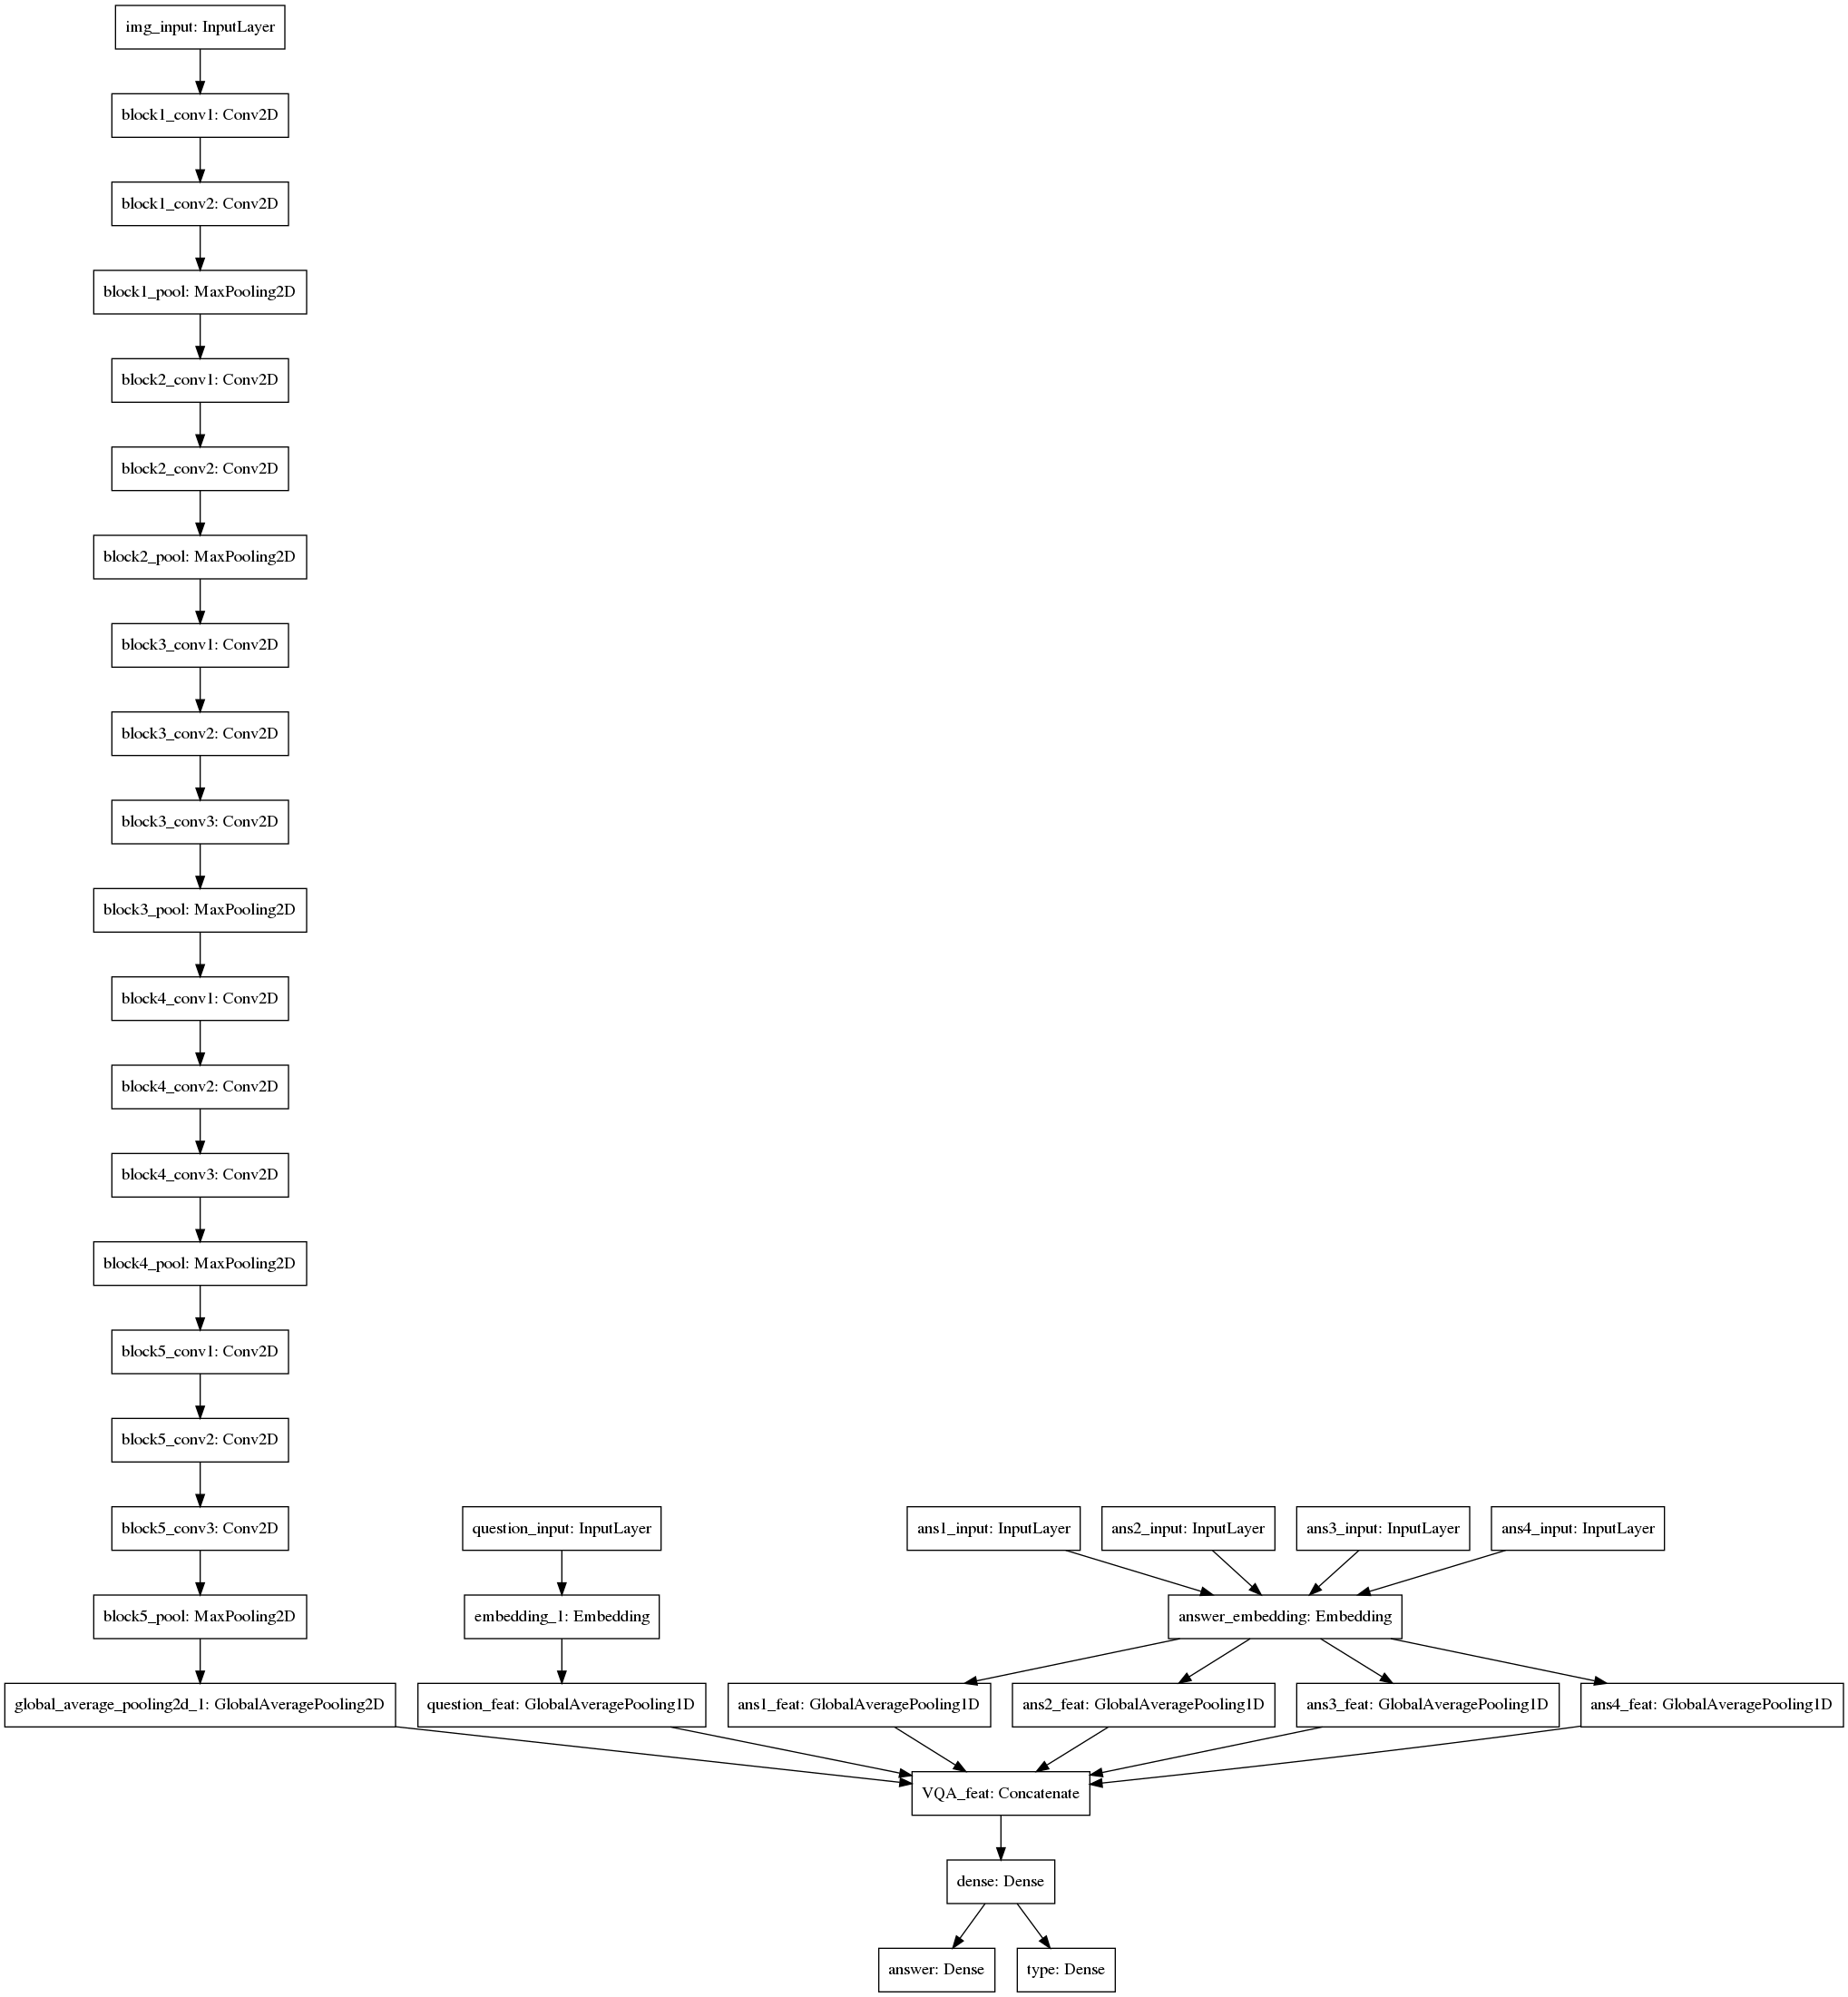

In [24]:
tf.keras.utils.plot_model(model)

In [25]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img_input (InputLayer)          [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        img_input[0][0]                  
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
______________________________________________________________________________________________